In [8]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [50]:
query = ("https://data.cityofnewyork.us/resource/cqsj-cfgu.json")
df_field = pd.read_json(query)
df_field.head()

,borough,from_,index,loc,may07_am,may07_d,may07_d2,may07_md,may07_pm,may08_am,...,sept13_md,sept13_pm,sept14_am,sept14_d,sept14_d2,sept14_md,sept14_pm,street,the_geom,to
0,Bronx,West 231st Street,N,1,1189,5/10/2007,5/5/2007,2508,4094,802,...,3008,4590,1450,09/04/14,09/06/14,2996,4646,Broadway,"{'type': 'Point', 'coordinates': [-73.90459140...",Naples Terrace
1,Bronx,Grand Concourse,Y,2,1511,5/10/2007,5/5/2007,1971,3184,1136,...,1832,3890,1949,09/11/14,09/13/14,2388,4435,East 161st Street,"{'type': 'Point', 'coordinates': [-73.92188432...",Sheridan Avenue
2,Bronx,Valentine Avenue,Y,3,1832,5/10/2007,5/5/2007,14391,12311,1061,...,8241,10613,2752,09/04/14,09/06/14,8266,10408,East Fordham Road,"{'type': 'Point', 'coordinates': [-73.89535781...",Tiebout Avenue
3,Bronx,Bainbridge Avenue,N,4,764,5/10/2007,5/5/2007,1798,2673,2102,...,1914,3660,2382,09/04/14,09/06/14,1339,3425,East Gun Hill Road,"{'type': 'Point', 'coordinates': [-73.87892467...",Rochambeau Avenue
4,Bronx,Prospect Avenue,N,5,650,5/10/2007,5/5/2007,2334,2538,553,...,2805,3488,1019,09/04/14,09/06/14,2366,3184,East Tremont Avenue,"{'type': 'Point', 'coordinates': [-73.88956389...",Clinton Avenue


In [51]:
df_field['avg_ped_field_all'] = df_field.filter(regex='_am|_md|_pm').mean(axis=1)
df_field['avg_ped_field_md'] = df_field.filter(regex='_md').mean(axis=1)
df_field['avg_ped_field_am'] = df_field.filter(regex='_am').mean(axis=1)
df_field['avg_ped_field_pm'] = df_field.filter(regex='_pm').mean(axis=1)

In [52]:
df_cnn = pd.read_csv("../data/dataframe/nyc-cnn-exp.csv")
df_cnn_agg = df_cnn.groupby('lid').agg('sum')[['ped_exp']]

In [55]:
df = df_field.join(df_cnn_agg)[['avg_ped_field_all',
                               'avg_ped_field_md',
                               'avg_ped_field_am',
                               'avg_ped_field_pm',
                               'ped_exp']]

In [56]:
df.head()

,avg_ped_field_all,avg_ped_field_md,avg_ped_field_am,avg_ped_field_pm,ped_exp
0,2698.352941,2847.235294,1145.294118,4102.529412,53.939207
1,2383.568627,1866.058824,1768.000000,3516.647059,17.533056
2,7357.411765,8744.823529,2316.352941,11011.058824,69.492603
3,2256.294118,1582.470588,2002.882353,3183.529412,49.163112
4,2453.313725,2728.235294,897.647059,3734.058824,45.036099


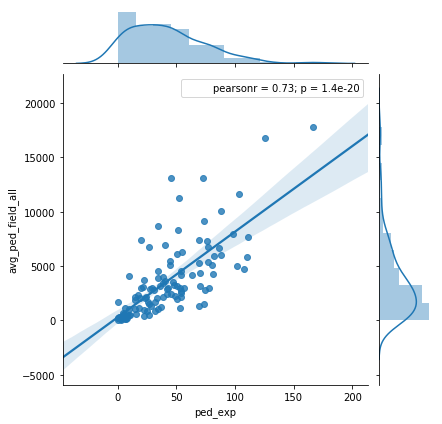

In [45]:
sns.jointplot(x="ped_exp", y="avg_ped_field_all", data=df, kind="reg")
plt.show()

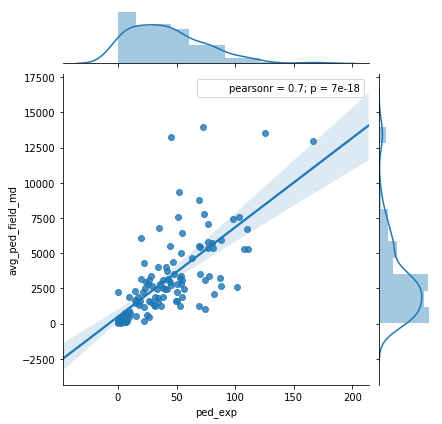

In [46]:
sns.jointplot(x="ped_exp", y="avg_ped_field_md", data=df, kind="reg")
plt.show()

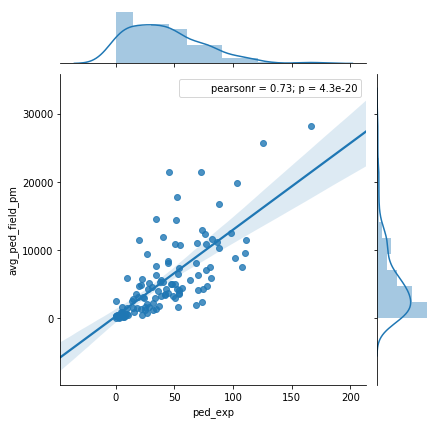

In [47]:
sns.jointplot(x="ped_exp", y="avg_ped_field_pm", data=df, kind="reg")
plt.show()

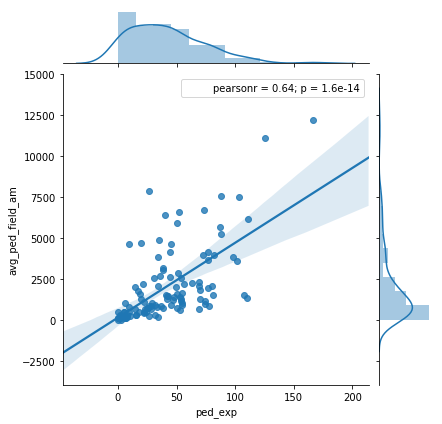

In [48]:
sns.jointplot(x="ped_exp", y="avg_ped_field_am", data=df, kind="reg")
plt.show()